In [204]:

import findspark
findspark.init()
# Import SparkSession
from pyspark.sql import SparkSession
import os
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType,BooleanType
from pyspark.sql.functions import *

train_schema = StructType([
    StructField("id", StringType(), True),
    StructField("date",DateType(), True),
    StructField("store_nbr", IntegerType(), True),
    StructField("family", StringType(), True),
    StructField("Sales", StringType(), True),
    StructField("onpromotion", StringType(), True)
])

holiday_schema  = StructType([
    StructField("Date", DateType(), True),
    StructField("type", StringType(), True),
    StructField("locale", StringType(), True),
    StructField("locale_name", StringType(), True),
    StructField("description", StringType(), True),
    StructField("transferred", BooleanType(), True)
])

oil_schema = StructType([
    StructField("date", DateType(), True),
    StructField("dcoilwtico", StringType(), True),
    
])

stores_schema = StructType([
    StructField("store_nbr", IntegerType(), True),
    StructField("city", StringType(), True),
    StructField("state", StringType(), True),
    StructField("type", StringType(), True),
    StructField("cluster", StringType(), True),
    
])

test_schema = StructType([
    StructField("id", StringType(), True),
    StructField("date", DateType(), True),
    StructField("store_nbr", IntegerType(), True),
    StructField("family", StringType(), True),
    StructField("onpromotion", StringType(), True),
    
])

transactions_schema = StructType([
    StructField("date", DateType(), True),
    StructField("store_nbr", IntegerType(), True),
    StructField("transactions", StringType(), True)
    
])



# Get path to directory (we all have unique paths to the repo)
__location__ = os.path.realpath(
    os.path.join(os.getcwd(), os.path.dirname('/home/robert/Downloads/store-sales-time-series-forecasting')))

# Create SparkSession 
spark = SparkSession.builder \
      .master("local[1]") \
      .appName("dataProject") \
      .getOrCreate() 


# Read in data (this method felt easy to understand, but is verbose)
train_df = spark.read.csv(os.path.join(__location__) + "/store-sales-time-series-forecasting/train.csv",schema=train_schema,header=True)

holidays_events_df = spark.read.csv(os.path.join(__location__) + "/store-sales-time-series-forecasting/holidays_events.csv",
schema=holiday_schema,header=True)

oil_df = spark.read.csv(os.path.join(__location__) + "/store-sales-time-series-forecasting/oil.csv",schema=oil_schema,header=True)

stores_df = spark.read.csv(os.path.join(__location__) + "/store-sales-time-series-forecasting/stores.csv",schema=stores_schema,header=True)

test_df = spark.read.csv(os.path.join(__location__) + "/store-sales-time-series-forecasting/test.csv",schema=test_schema,header=True)

transactions_df = spark.read.csv(os.path.join(__location__) + "/store-sales-time-series-forecasting/transactions.csv",
schema=transactions_schema,header=True)



# If you want to see how it looks like
#train_df.show()
#holidays_events_df.show()
#oil_df.show()
#stores_df.show()
#test_df.show()
#transactions_df.show()


In [205]:

total_records = train_df.count()
first_date = train_df.head()['date']
last_date = train_df.tail(1)[0].date
total_days = last_date-first_date
store_nbr_id = stores_df.select("store_nbr").distinct().count()
family_unique = train_df.select("family").distinct().count()
stores_city = stores_df.select("city").distinct().count()
stores_state = stores_df.select("state").distinct().count()




In [206]:
print("Basic records:")
print("There are {} records, spanned from {} to {}.".format(total_records,first_date,last_date))
print("There are in total {}.".format(total_days))
print("There are {} distinct stores.".format(store_nbr_id))
print("There are in total {} product families.".format(family_unique))
print("Thre are {} cities and {} states.".format(stores_city,stores_state))

Basic records:
There are 3000888 records, spanned from 2013-01-01 to 2017-08-15.
There are in total 1687 days, 0:00:00.
There are 54 distinct stores.
There are in total 33 product families.
Thre are 22 cities and 16 states.


In [207]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator

import seaborn as sns
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))




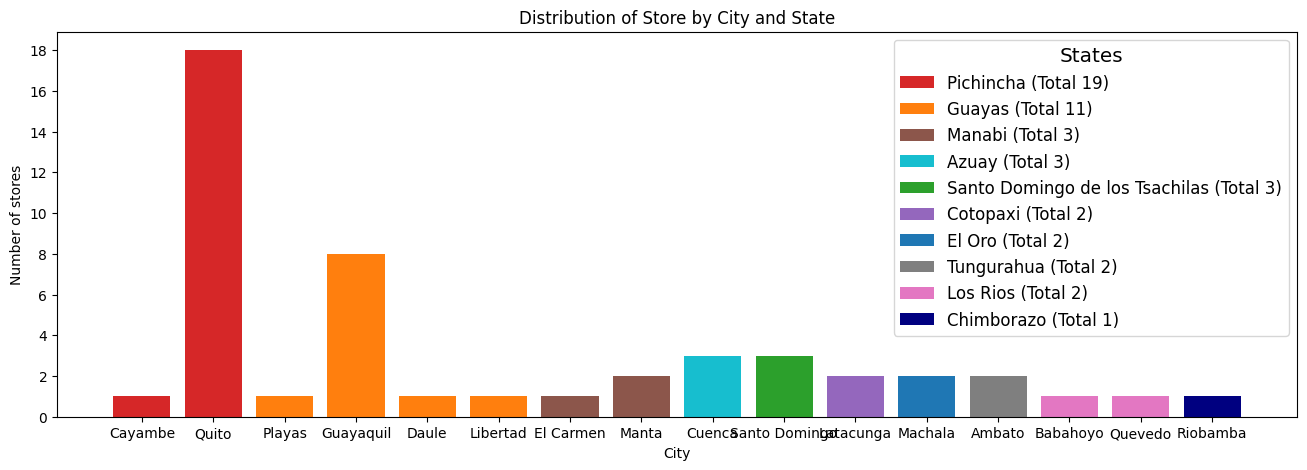

In [208]:
top_city_df = stores_df.groupBy('city').count().sort(desc("count"))
top_state_df = stores_df.groupBy('state').count().sort(desc("count"))
top_state = top_state_df.select(['state','count']).rdd.map(lambda r: (r[0],r[1])).collect()


stores_data_grouped = stores_df.groupBy(['state','city']).agg(count('city').alias('count'))

color = ["tab:red","tab:orange","tab:brown","tab:cyan","tab:green","tab:purple","tab:blue","tab:gray","tab:pink", "navy","darkred"]
fig, ax = plt.subplots( figsize=(16,5))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("Distribution of Store by City and State")
ax.set_ylabel("Number of stores")
ax.set_xlabel("City")
custom_label=[]
custom_legend = []
for i in range(0,10):
    u = stores_data_grouped.filter(stores_data_grouped.state == top_state[i][0])
    ax.bar(u.select(['city']).rdd.map(lambda r: r[0]).collect(), 
    u.select(['count']).rdd.map(lambda r: r[0]).collect(),color=color[i])
    custom_label.append ( Patch(facecolor=color[i])  )
    custom_legend.append( top_state[i][0] + " (Total {})".format(top_state[i][1]))
ax.legend(custom_label, custom_legend, fontsize="large", labelcolor="black", 
          fancybox=True, title = "States", title_fontsize = "x-large")
plt.show()




In [209]:
sales_grouped = train_df.groupBy(['store_nbr','date']).agg(sum('sales').alias('sales'))
#sales_grouped.show()
sales_by_store_id = list()

for store in range(1,store_nbr_id+1):
    sales_by_store_id.append({'store':store,'sale':
    sales_grouped.filter(sales_grouped.store_nbr == store).select(avg("sales").alias('sales')).first()['sales'],
    'city':stores_df.filter(stores_df.store_nbr == store).select('city').first()['city'],
    'city-id':stores_df.filter(stores_df.store_nbr == store).select('city').first()['city']+"-{}".format(store),
    'state':stores_df.filter(stores_df.store_nbr == store).select('state').first()['state'],
    'type':stores_df.filter(stores_df.store_nbr == store).select('type').first()['type'],
    'cluster':stores_df.filter(stores_df.store_nbr == store).select('cluster').first()['cluster']})
sales_by_store_id = spark.createDataFrame(sales_by_store_id)
#sales_by_store_id.show()

In [210]:
top_city = top_city_df.select(['city']).rdd.map(lambda r: r[0]).collect()

sales_by_city = list()
top_state = top_state_df.select(['state','count']).rdd.map(lambda r: (r[0],r[1])).collect()



for city_ in top_city:
    sales_by_city.append({'city':city_,
    'sum':sales_by_store_id.filter(sales_by_store_id.city == city_).agg({'sale':'sum'}).first()['sum(sale)'],
    'mean':sales_by_store_id.filter(sales_by_store_id.city == city_).agg({'sale':'avg'}).first()['avg(sale)']})
sales_by_city = spark.createDataFrame(sales_city)
sales_by_city.show()


+-------------+------------------+------------------+
|         city|              mean|               sum|
+-------------+------------------+------------------+
|        Quito|18367.043970308885| 330606.7914655599|
|    Guayaquil|  9127.61731605227| 73020.93852841816|
|       Cuenca| 9732.501194216371|29197.503582649115|
|Santo Domingo| 7093.096404852021| 21279.28921455606|
|        Manta| 4130.741394279126| 8261.482788558253|
|    Latacunga| 6289.270717095014|12578.541434190029|
|       Ambato|11966.864993944182|23933.729987888364|
|      Machala| 9912.944342206772|19825.888684413545|
|      Quevedo| 8419.537585183494| 8419.537585183494|
|     Guaranda| 7749.115104948334| 7749.115104948334|
|       Playas|  4558.59823139525|  4558.59823139525|
|         Puyo| 2428.860891211402| 2428.860891211402|
|         Loja|11199.524501502136|11199.524501502136|
|       Ibarra|  6800.04158114489|  6800.04158114489|
|    El Carmen|  6566.20137642809|  6566.20137642809|
|        Daule|11394.3119842

In [211]:
sales_by_store_id = sales_by_store_id.orderBy(['sale'],ascending=[False])
sales_by_city_sum = sales_by_city.orderBy(['sum'],ascending=[False])
sales_by_city_sum.show()
#sales_by_store_id.filter(sales_by_store_id.city == "Q").show()

+-------------+------------------+------------------+
|         city|              mean|               sum|
+-------------+------------------+------------------+
|        Quito|18367.043970308885| 330606.7914655599|
|    Guayaquil|  9127.61731605227| 73020.93852841816|
|       Cuenca| 9732.501194216371|29197.503582649115|
|       Ambato|11966.864993944182|23933.729987888364|
|Santo Domingo| 7093.096404852021| 21279.28921455606|
|      Machala| 9912.944342206772|19825.888684413545|
|      Cayambe|  16820.4028986912|  16820.4028986912|
|    Latacunga| 6289.270717095014|12578.541434190029|
|        Daule|11394.311984283964|11394.311984283964|
|         Loja|11199.524501502136|11199.524501502136|
|     Babahoyo| 10538.52298189252| 10538.52298189252|
|   Esmeraldas| 9733.783973818056| 9733.783973818056|
|     Libertad| 9098.830817445361| 9098.830817445361|
|      Quevedo| 8419.537585183494| 8419.537585183494|
|        Manta| 4130.741394279126| 8261.482788558253|
|     Guaranda| 7749.1151049

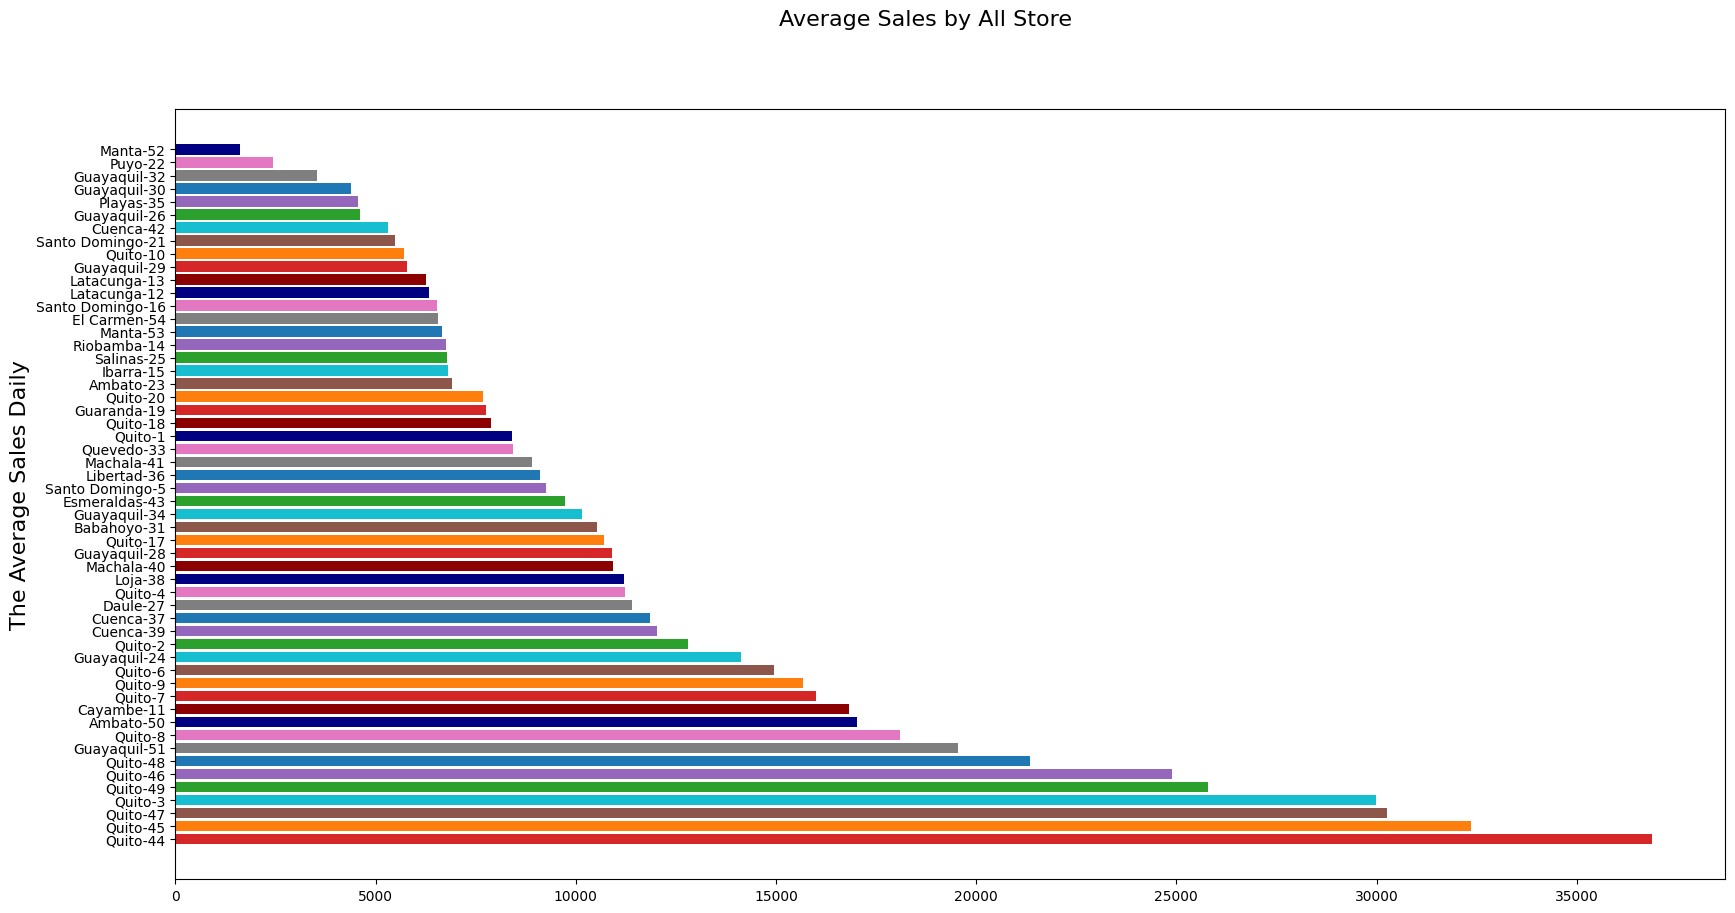

In [194]:
# Ploting
figsize = (20,10)
fig, ax0 = plt.subplots(figsize=figsize)
city_id = [val[0] for val in sales_by_store_id.select('city-id').collect()]
sale = [val[0] for val in sales_by_store_id.select('sale').collect()]
plt.barh(city_id,sale,color=color, align='center')
plt.suptitle("Average Sales by All Store",  fontsize=16, ha='center')
ax0.set_ylabel('The Average Sales Daily',  fontsize=16);

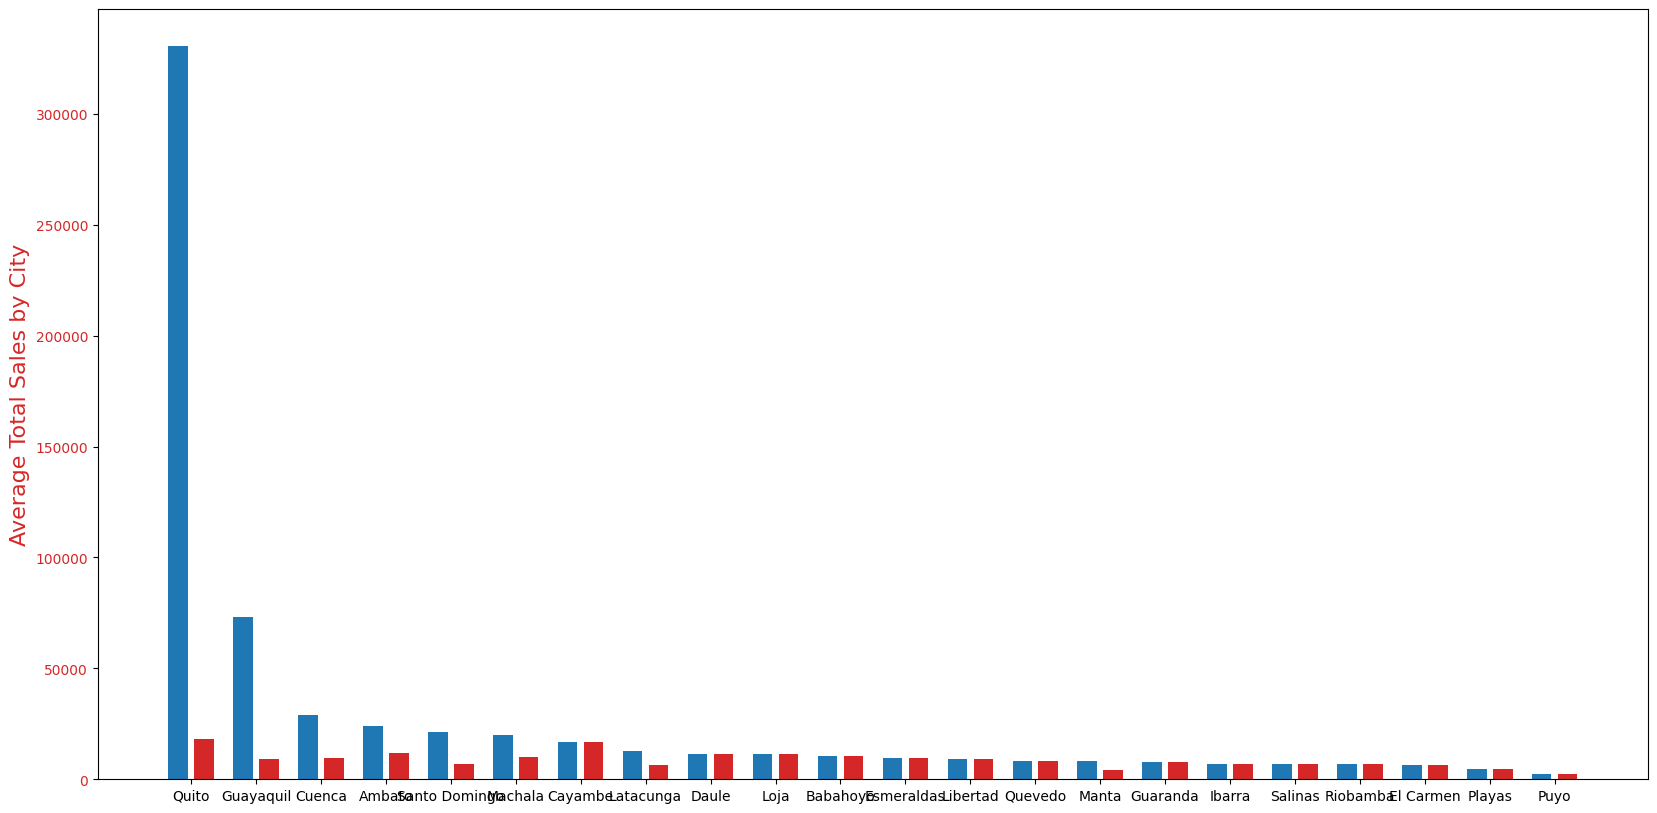

In [195]:
color1 = "tab:red"
color2 = "tab:blue"
fig, ax1 = plt.subplots(figsize=figsize)
sum = [val[0] for val in sales_by_city_sum.select('sum').collect()]

mean = [val[0] for val in sales_by_city_sum.select('mean').collect()]
cities = [val[0] for val in sales_by_city_sum.select('city').collect()]
x = np.arange(len(cities))
plt.bar(x-0.2,sum,color=color2,width=0.3)

plt.bar(x+0.2,mean,color=color1,width=0.3)
plt.xticks(x,cities)

############# Style Set up ###############
ax1.set_ylabel('Average Total Sales by City', color=color1, fontsize=16)
ax1.tick_params(axis='y', labelcolor=color1)
ax2.set_ylabel('Average Sales by Store by City', color=color2, fontsize=16)  
ax2.tick_params(axis='y', labelcolor=color2)